In [23]:
!pip install pyspark

In [24]:
!pip install xgboost

In [25]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

Downloading Dataset From Kaggle

In [26]:
import kagglehub


path = kagglehub.dataset_download("ziya07/smart-grid-real-time-load-monitoring-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'smart-grid-real-time-load-monitoring-dataset' dataset.
Path to dataset files: /kaggle/input/smart-grid-real-time-load-monitoring-dataset


In [27]:
df = spark.read.format("csv").load("/content/smart_grid_dataset.csv", header=True, inferSchema=True)

df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Voltage: double (nullable = true)
 |-- Current : double (nullable = true)
 |-- Power_Consumption: double (nullable = true)
 |-- Reactive_Power: double (nullable = true)
 |-- Power_Factor: double (nullable = true)
 |-- Solar_Power: double (nullable = true)
 |-- Wind_Power: double (nullable = true)
 |-- Grid_Supply: double (nullable = true)
 |-- Voltage_Fluctuation: double (nullable = true)
 |-- Overload_Condition: integer (nullable = true)
 |-- Transformer_Fault: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Electricity_Price(USD/kWh): double (nullable = true)
 |-- Predicted_Load: double (nullable = true)



In [28]:
from pyspark.sql.functions import monotonically_increasing_id

df = df.withColumn('id', monotonically_increasing_id())

df = df[['id'] + df.columns[:-1]]

df.show(3)

+---+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------+--------------------+------------------+-----------------+------------------+-----------------+--------------------------+------------------+
| id|          Timestamp|           Voltage|         Current | Power_Consumption|    Reactive_Power|      Power_Factor|      Solar_Power|        Wind_Power|Grid_Supply| Voltage_Fluctuation|Overload_Condition|Transformer_Fault|       Temperature|         Humidity|Electricity_Price(USD/kWh)|    Predicted_Load|
+---+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------+--------------------+------------------+-----------------+------------------+-----------------+--------------------------+------------------+
|  0|2024-01-01 00:00:00|232.48357076505616|5.124672741462765|1.191402

In [29]:
df.count()

50000

In [30]:
df.select('Power_Factor').agg({'Power_Factor': 'avg'}).show()

+------------------+
| avg(Power_Factor)|
+------------------+
|0.8999973660450433|
+------------------+



In [31]:
from pyspark.sql.functions import mean

df.select(*[mean(c) for c in df.columns]).show()

+-------+--------------+-----------------+-----------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+------------------------+-----------------------+----------------------+------------------+------------------+-------------------------------+-------------------+
|avg(id)|avg(Timestamp)|     avg(Voltage)|    avg(Current )|avg(Power_Consumption)|avg(Reactive_Power)| avg(Power_Factor)|  avg(Solar_Power)|   avg(Wind_Power)|    avg(Grid_Supply)|avg(Voltage_Fluctuation)|avg(Overload_Condition)|avg(Transformer_Fault)|  avg(Temperature)|     avg(Humidity)|avg(Electricity_Price(USD/kWh))|avg(Predicted_Load)|
+-------+--------------+-----------------+-----------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+------------------------+-----------------------+----------------------+------------------+------------------+---------------------

In [32]:
df.groupby('Temperature').agg({col: 'avg' for col in df.columns[3:-1]}).show()

+------------------+-------------------------------+----------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------------+----------------------+------------------+-----------------------+
|       Temperature|avg(Electricity_Price(USD/kWh))|avg(Power_Consumption)| avg(Power_Factor)|     avg(Current )|     avg(Humidity)|  avg(Solar_Power)|    avg(Wind_Power)|avg(Reactive_Power)|  avg(Temperature)|avg(Voltage_Fluctuation)|avg(Transformer_Fault)|  avg(Grid_Supply)|avg(Overload_Condition)|
+------------------+-------------------------------+----------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------------+----------------------+------------------+-----------------------+
|31.612430932541315|            0.11851153864134392|     9.085485914347819|0.8797509034932891|

In [33]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def squared(value):
  return value * value

squared_udf = udf(squared, FloatType())

df.withColumn('Current_squared', squared_udf('Current ')).show(5)

+---+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------+--------------------+------------------+-----------------+------------------+-----------------+--------------------------+------------------+---------------+
| id|          Timestamp|           Voltage|         Current | Power_Consumption|    Reactive_Power|      Power_Factor|       Solar_Power|        Wind_Power|Grid_Supply| Voltage_Fluctuation|Overload_Condition|Transformer_Fault|       Temperature|         Humidity|Electricity_Price(USD/kWh)|    Predicted_Load|Current_squared|
+---+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------+--------------------+------------------+-----------------+------------------+-----------------+--------------------------+------------------+---------------+
|  0|2024-01-01 00:

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Define feature columns (excluding 'Timestamp', 'id', and the target 'Predicted_Load')
feature_cols = [col for col in df.columns if col not in ['Timestamp', 'id', 'Predicted_Load']]

# Assemble features into a single vector column
# The original column 'Current ' has a trailing space, so it's included as is.
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the DataFrame
df_assembled = assembler.transform(df)

# Show the schema to confirm the new 'features' column
df_assembled.printSchema()

root
 |-- id: long (nullable = false)
 |-- Timestamp: timestamp (nullable = true)
 |-- Voltage: double (nullable = true)
 |-- Current : double (nullable = true)
 |-- Power_Consumption: double (nullable = true)
 |-- Reactive_Power: double (nullable = true)
 |-- Power_Factor: double (nullable = true)
 |-- Solar_Power: double (nullable = true)
 |-- Wind_Power: double (nullable = true)
 |-- Grid_Supply: double (nullable = true)
 |-- Voltage_Fluctuation: double (nullable = true)
 |-- Overload_Condition: integer (nullable = true)
 |-- Transformer_Fault: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Electricity_Price(USD/kWh): double (nullable = true)
 |-- Predicted_Load: double (nullable = true)
 |-- features: vector (nullable = true)



In [35]:
# Split the data into training and test sets
(training_data, test_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)

print(f"Training data count: {training_data.count()}")
print(f"Test data count: {test_data.count()}")

Training data count: 39948
Test data count: 10052


In [36]:
# Initialize GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="Predicted_Load", maxIter=10, seed=42)

# Train model
model = gbt.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Predicted_Load", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Show some predictions
predictions.select("Predicted_Load", "prediction", "features").show(5)

Root Mean Squared Error (RMSE) on test data = 0.22256119165686045
+------------------+------------------+--------------------+
|    Predicted_Load|        prediction|            features|
+------------------+------------------+--------------------+
|10.580278295882652|10.681176491923745|[233.238442690503...|
|1.2290654100695328|   1.3040630153974|[237.896064077536...|
|1.8075437092282034|1.9013186500270898|[227.652628070325...|
| 6.991575161047127| 7.376807658056762|[220.433598776711...|
|  8.34516328321125| 8.717411836079465|[222.938481493323...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [37]:
# Initialize GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="Predicted_Load", maxIter=10, seed=42)

# Train model
model = gbt.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Predicted_Load", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Show some predictions
predictions.select("Predicted_Load", "prediction", "features").show(5)

Root Mean Squared Error (RMSE) on test data = 0.22256119165686045
+------------------+------------------+--------------------+
|    Predicted_Load|        prediction|            features|
+------------------+------------------+--------------------+
|10.580278295882652|10.681176491923745|[233.238442690503...|
|1.2290654100695328|   1.3040630153974|[237.896064077536...|
|1.8075437092282034|1.9013186500270898|[227.652628070325...|
| 6.991575161047127| 7.376807658056762|[220.433598776711...|
|  8.34516328321125| 8.717411836079465|[222.938481493323...|
+------------------+------------------+--------------------+
only showing top 5 rows



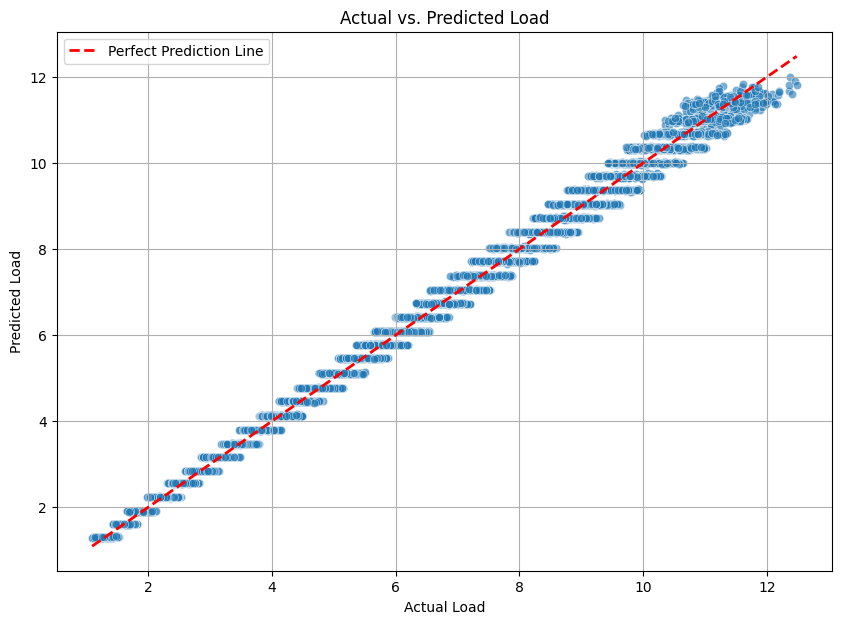

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to a Pandas DataFrame for plotting
predictions_pd = predictions.select("Predicted_Load", "prediction").toPandas()

# Create a scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Predicted_Load', y='prediction', data=predictions_pd, alpha=0.6)

# Add a diagonal line for perfect predictions
min_val = min(predictions_pd['Predicted_Load'].min(), predictions_pd['prediction'].min())
max_val = max(predictions_pd['Predicted_Load'].max(), predictions_pd['prediction'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction Line')

plt.title('Actual vs. Predicted Load')
plt.xlabel('Actual Load')
plt.ylabel('Predicted Load')
plt.grid(True)
plt.legend()
plt.show()